# Coursework 3: Part A - RNNs

#### Instructions

Please submit on CATe a zip file named *CW3_RNNs.zip* containing a version of this notebook containing your answers. Write your answers in the cells below each question.


#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 5th March, 2020**

## Recurrent models coursework

This coursework is separated into a coding and a theory component.

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the tutorial part (http://www.doc.ic.ac.uk/~pam213/co460_files).

### Part 1 - Coding (70%)
In this part you will have to:

#### Part 1.1 (20%)

Implement the LSTM RNN cell.

#### Part 1.2 (30%)

- Modify the RNNModel class, such that it is a Bidirectional RNN.
- Compare vanilla RNN, GRU, LSTM, and bidirectional VS unidirectional RNNs and report their performance with respect to accuracy and time cost.

#### Part 1.3 (20%)

Then for your best model you will perform some improvements:
- In terms of architecture optimisation (number of layers, hidden state dimension)
- Better utilisation of the hidden state sequence output by the RNN, for classification.
- Report the improvements you achieved, as well as an explanation for why they worked.

### Part 2 - Theory (30%)

Here you will answer some theoretical questions about RNN training, and CTC -- no detailed proofs and no programming.

### Part 1: Coding

### Dataset

We will be using the Google [*Speech Commands*](https://www.tensorflow.org/tutorials/sequences/audio_recognition) v0.02 [1] dataset.

[1] Warden, P. (2018). [Speech commands: A dataset for limited-vocabulary speech recognition](https://arxiv.org/abs/1804.03209). *arXiv preprint arXiv:1804.03209.*

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the tutorial part (http://www.doc.ic.ac.uk/~pam213/co460_files).

Set-up code and imports

In [0]:
# ! wget https://www.doc.ic.ac.uk/~pam213/co460_files/data_speech_commands_v0.02.zip
# ! mkdir ./data/
# ! mkdir ./data/data_speech_commands_v0.02
# ! unzip -q data_speech_commands_v0.02.zip -d ./data/data_speech_commands_v0.02

# ! wget https://www.doc.ic.ac.uk/~pam213/co460_files/happy_male.wav
# ! wget https://www.doc.ic.ac.uk/~pam213/co460_files/yes_female.wav
# ! wget https://www.doc.ic.ac.uk/~pam213/co460_files/yes_male.wav

In [0]:
import math
import os
from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

 Data provider class definition.

Here you can give different configuration to the [mfcc function](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html). Additional keyword arguments are defined in the [melspectrogram function](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram).

One may additionally consider standardising the samples (remove mean, divide by std) or performing data augmentation, e.g., by adding low variance white or noise.

In [0]:
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split

        self.number_of_classes = len(self.get_classes())

        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "/data_speech_commands_v0.02/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "/data_speech_commands_v0.02/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)

    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        ########################################################################
        ## YOU MAY CONFIGURE HERE.
        ########################################################################
        sample = librosa.feature.mfcc(y=sample, sr=16000, hop_length=512, n_fft=2048).transpose().astype(np.float32)
        ########################################################################
        ## DO NOT CONFIGURE BEYOND HERE.
        ########################################################################
        
        label = self.label_list[idx]

        return sample, label

    def get_classes(self):
        return ['one', 'two', 'three']

    def get_valid_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/data_speech_commands_v0.02/validation_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/data_speech_commands_v0.02/testing_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

Load Dataset - you may vary batch size.

In [0]:
## MAKE SURE THIS POINTS INSIDE THE DATASET FOLDER.
dataset_folder = "data" # this should change depending on where you have stored the data files

train_dataset = SpeechCommandsDataset(dataset_folder,
                                      "train")
valid_dataset = SpeechCommandsDataset(dataset_folder,
                                      "valid")

test_dataset = SpeechCommandsDataset(dataset_folder,
                                     "test")

## YOU MAY CHANGE THE BATCH SIZE.
batch_size = 100

num_epochs = 5
valid_every_n_steps = 20
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## Part 1.1 (20%)

Finalise the LSTM cell (you can base your code on that of the GRU cell).

You are allowed to use nn.Linear.

In [5]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        # Input gate i
        self.i_x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.i_h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        # Forget gate
        self.f_x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.f_h2h = nn.Linear(hidden_size, hidden_size, bias=bias)           

        # Input gate g
        self.g_x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.g_h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        # Output gate
        self.o_x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.o_h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hx = (hx, hx)
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        hx, cx = hx

        # Input gate i
        i = torch.sigmoid(self.i_h2h(hx) + self.i_x2h(input))

        # Forget gate
        f = torch.sigmoid(self.f_h2h(hx) + self.f_x2h(input))

        # Input gate g
        g = torch.tanh(self.g_h2h(hx) + self.g_x2h(input))

        # Output gate
        o = torch.sigmoid(self.o_h2h(hx) + self.o_x2h(input))

        # Update gate
        cy = f * cx + i * g

        # Next hidden state
        hy = o * torch.tanh(cy)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        return (hy, cy)

# Test code
input_size, hidden_size = 10, 20
bias = True

lstm_ = nn.LSTMCell(input_size, hidden_size, bias)
lstm = LSTMCell(input_size, hidden_size, bias)

lstm.i_x2h.weight.data, lstm.f_x2h.weight.data, lstm.g_x2h.weight.data, lstm.o_x2h.weight.data = lstm_.weight_ih.data.chunk(4, 0)
lstm.i_h2h.weight.data, lstm.f_h2h.weight.data, lstm.g_h2h.weight.data, lstm.o_h2h.weight.data = lstm_.weight_hh.data.chunk(4, 0)
if bias:
    lstm.i_x2h.bias.data, lstm.f_x2h.bias.data, lstm.g_x2h.bias.data, lstm.o_x2h.bias.data = lstm_.bias_ih.data.chunk(4, 0)
    lstm.i_h2h.bias.data, lstm.f_h2h.bias.data, lstm.g_h2h.bias.data, lstm.o_h2h.bias.data = lstm_.bias_hh.data.chunk(4, 0)

test = torch.ones(6, 3, input_size)
hx = hx_ = (torch.ones(3, hidden_size), torch.ones(3, hidden_size))
output, output_ = [], []
for i in range(6):

    hx = lstm(test[i], hx)
    output.append(hx)

    hx_ = lstm_(test[i], hx_)
    output_.append(hx_)

    assert (hx[0] - hx_[0]).abs().max() < 1e-6, "Some values don't match"
    assert (hx[1] - hx_[1]).abs().max() < 1e-6, "Some values don't match"

print('Values match!')

Values match!


In [6]:
class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(BasicRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

            
    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        nonlin = torch.tanh if self.nonlinearity == 'tanh' else torch.relu
        hy = nonlin(self.h2h(hx) + self.x2h(input))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
            
        return hy

# Test code
input_size, hidden_size = 10, 20
bias, nonlinearity = True, "relu"

rnn_ = nn.RNNCell(input_size, hidden_size, bias, nonlinearity)
rnn = BasicRNNCell(input_size, hidden_size, bias, nonlinearity)

rnn_.weight_ih.data = rnn.x2h.weight.data.clone()
rnn_.weight_hh.data = rnn.h2h.weight.data.clone()
if bias:
    rnn_.bias_ih.data = rnn.x2h.bias.data.clone()
    rnn_.bias_hh.data = rnn.h2h.bias.data.clone()

test = torch.ones(6, 3, input_size)
hx = hx_ = torch.ones(3, hidden_size)
output, output_ = [], []
for i in range(6):
    hx = rnn(test[i], hx)
    output.append(hx)

    hx_ = rnn_(test[i], hx_)
    output_.append(hx_)

    assert (hx - hx_).abs().max() < 1e-6, "Some values don't match"

print('Values match!')

Values match!


In [7]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        # Reset gate
        self.r_x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.r_h2h = nn.Linear(hidden_size, hidden_size, bias=bias)           

        # Update gate
        self.z_x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.z_h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        # Input gate
        self.g_x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.g_h2h = nn.Linear(hidden_size, hidden_size, bias=bias)           

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        # Reset gate
        r = torch.sigmoid(self.r_h2h(hx) + self.r_x2h(input))

        # Update gate
        z = torch.sigmoid(self.z_h2h(hx) + self.z_x2h(input))

        # Input gate
        g = torch.tanh(r * self.g_h2h(hx) + self.g_x2h(input))

        # Next hidden state
        hy = z * hx + (1-z) * g

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return hy

# Test code
input_size, hidden_size = 10, 20
bias = True

rnn_ = nn.GRUCell(input_size, hidden_size, bias)
rnn = GRUCell(input_size, hidden_size, bias)

rnn.r_x2h.weight.data, rnn.z_x2h.weight.data, rnn.g_x2h.weight.data = rnn_.weight_ih.data.chunk(3, 0)
rnn.r_h2h.weight.data, rnn.z_h2h.weight.data, rnn.g_h2h.weight.data = rnn_.weight_hh.data.chunk(3, 0)
if bias:
    rnn.r_x2h.bias.data, rnn.z_x2h.bias.data, rnn.g_x2h.bias.data = rnn_.bias_ih.data.chunk(3, 0)
    rnn.r_h2h.bias.data, rnn.z_h2h.bias.data, rnn.g_h2h.bias.data = rnn_.bias_hh.data.chunk(3, 0)

test = torch.ones(6, 3, input_size)
hx = hx_ = torch.ones(3, hidden_size)
output, output_ = [], []
for i in range(6):
    hx = rnn(test[i], hx)
    output.append(hx)

    hx_ = rnn_(test[i], hx_)
    output_.append(hx_)

    assert (hx - hx_).abs().max() < 1e-6, "Some values don't match"

print("Values match!")

Values match!


In [0]:
class RNNModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(RNNModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        
        if mode == 'LSTM':
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))           
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, input, hx=None):
        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))

        else:
             h0 = hx

        outs = []

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        if self.mode == 'LSTM':
            h0 = (h0, h0)

            hs = [h0]
            # Iterate over sequence
            for seq_id in range(input.size(1)):

                inp = input[:,seq_id,:]
                hs.append((torch.zeros_like(h0[0]), torch.zeros_like(h0[1])))

                # Forward pass through every subsequent layer
                for layer_id, cell in enumerate(self.rnn_cell_list):
                    # Feed input through LSTM
                    hx, cx = cell(inp, (hs[seq_id][0][layer_id,:,:], hs[seq_id][1][layer_id,:,:]))
                    # Save cell state and hidden state
                    hs[seq_id+1][0][layer_id], hs[seq_id+1][1][layer_id] = hx, cx
                    # Input hidden state into next layer
                    inp = hx

                outs.append(inp)

        else:
            hs = [h0]
            # Iterate over sequence
            for seq_id in range(input.size(1)):

                inp = input[:,seq_id,:]
                hs.append(torch.zeros_like(h0))

                # Forward pass through every subsequent layer
                for layer_id, cell in enumerate(self.rnn_cell_list):
                    # Feed input through RNN
                    inp = cell(inp, hs[seq_id][layer_id,:,:])
                    # Save hidden state
                    hs[seq_id+1][layer_id] = inp

                outs.append(inp)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze() # Related to Part 1.3.

        out = self.fc(out)
        
        return out

# Test code
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
input_size, hidden_size = 10, 20
bias, mode = True, "LSTM"
num_layers, output_size = 2, 2

rnn = RNNModel(mode, input_size, hidden_size, num_layers, bias, output_size).to(device)

test = torch.ones(6, 1, input_size).to(device)
hx = hx_ = torch.zeros(num_layers, 3, hidden_size)
output, output_ = [], []

hx = rnn(test)

In [0]:
class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        if mode == 'LSTM':
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                            self.hidden_size,
                                            self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                self.hidden_size,
                                                self.bias))           

        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                            self.hidden_size,
                                            self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                self.hidden_size,
                                                self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                self.hidden_size,
                                                self.bias,
                                                "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                    self.hidden_size,
                                                    self.bias,
                                                    "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                self.hidden_size,
                                                self.bias,
                                                "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                self.hidden_size,
                                                self.bias,
                                                "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(self.hidden_size * 2, 1)
        self.fc = nn.Linear(self.hidden_size * 2, self.output_size)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
             
    def forward(self, input, hx=None):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
        if torch.cuda.is_available():
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))  
            
        outs = []
        outs_rev = []
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        if self.mode == 'LSTM':
            h0 = (h0, h0)
            hT = (hT, hT)

            hs = [h0]
            hs_rev = [hT]
            # Iterate over sequence
            for seq_id in range(input.size(1)):

                # Left to right
                inp = input[:,seq_id,:]
                hs.append((torch.zeros_like(h0[0]), torch.zeros_like(h0[0])))

                # Right to left
                inp_rev = input[:,-seq_id-1,:]
                hs_rev.append((torch.zeros_like(hT[0]), torch.zeros_like(hT[1])))

                # Forward pass through every subsequent layer
                for layer_id, cell in enumerate(self.rnn_cell_list):

                    ## Left to right
                    # Feed input through LSTM
                    hx, cx = cell(inp, (hs[seq_id][0][layer_id,:,:], hs[seq_id][1][layer_id,:,:]))
                    # Save cell state and hidden state
                    hs[seq_id+1][0][layer_id], hs[seq_id+1][1][layer_id] = hx, cx
                    # Input hidden state into next layer
                    inp = hx

                    ## Right to left
                    # Feed input through RNN
                    hx_rev, cx_rev = cell(inp_rev, (hs_rev[-seq_id-1][0][layer_id], hs_rev[-seq_id-1][1][layer_id]))
                    # Save hidden state
                    hs_rev[-seq_id-2][0][layer_id], hs_rev[-seq_id-2][1][layer_id] = hx_rev, cx_rev
                    # Input hidden state into next layer
                    inp_rev = hx_rev

                outs.append(inp)
                outs_rev.append(inp_rev)

        else:
            hs = [h0]
            hs_rev = [hT]
            # Iterate over sequence
            for seq_id in range(input.size(1)):

                # Left to right
                inp = input[:,seq_id,:]
                hs.append(torch.zeros_like(h0))

                # Right to left
                inp_rev = input[:,-seq_id-1,:]
                hs_rev.append(torch.zeros_like(hT))

                # Forward pass through every subsequent layer
                for layer_id, cell in enumerate(self.rnn_cell_list):

                    ## Left to right
                    # Feed input through RNN
                    inp = cell(inp, hs[seq_id][layer_id,:,:])
                    # Save hidden state
                    hs[seq_id+1][layer_id] = inp

                    ## Right to left
                    # Feed input through RNN
                    inp_rev = cell(inp_rev, hs_rev[-seq_id-1][layer_id])
                    # Save hidden state
                    hs_rev[-seq_id-2][layer_id] = inp_rev

                outs.append(inp)
                outs_rev.append(inp_rev)

        # Compute hidden state output
        if compute_output == 'maxpool':
            outs_tensor = torch.cat(outs).view((-1, )+outs[0].shape)
            out, _ = outs_tensor.max(dim=0)
            
            outs_rev_tensor = torch.cat(outs_rev).view((-1, )+outs_rev[0].shape)
            out_rev, _ = outs_rev_tensor.max(dim=0)

        elif compute_output == 'avg':
            outs_tensor = torch.cat(outs).view((-1, )+outs[0].shape)
            out = outs_tensor.mean(dim=0)
            
            outs_rev_tensor = torch.cat(outs_rev).view((-1, )+outs_rev[0].shape)
            out_rev = outs_rev_tensor.mean(dim=0)

        # elif compute_output == 'self_attention':
        #     pass

        # elif compute_output == 'multi_head_self_attention':
        #     pass

        else:
            out = outs[-1].squeeze()
            out_rev = outs_rev[0].squeeze()
        
        out = torch.cat((out, out_rev), 1)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = self.fc(out)
        return out

# Test code
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
input_size, hidden_size = 10, 20
bias, mode = True, "LSTM"
num_layers, output_size = 3, 2
compute_output = 'avg' # 'maxpool', 'avg', 'self_attention', 'multi_head_self_attention', 'original

birnn = BidirRecurrentModel(mode, input_size, hidden_size, num_layers, bias, output_size).to(device)

test = torch.ones(6, 3, input_size).to(device)
hx = hx_ = torch.zeros(num_layers, 3, hidden_size)
output, output_ = [], []

hx = birnn(test)

## Part 1.2 (30%)

In the following, experiment with different RNN architectures (RNN cell types, number of layers, hidden state dimensionality, MFCC configuration, unidirectional VS bidirectional) and report the accuracy (pay also attention to the training and validation cost), as well as training time. 

* What are your justifications for these results?

* On the notebook, leave the execution of your best model.

In [0]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch
seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

def train_model(config: dict):
    hidden_dim = config['hidden_dim']
    layer_dim = config['layer_dim']
    bias = config['bias']
    mode = config['mode']

    if config['bidir'] is True:
        model = BidirRecurrentModel(mode, input_dim, hidden_dim, layer_dim, bias, output_dim)
    else:
        model = RNNModel(mode, input_dim, hidden_dim, layer_dim, bias, output_dim)

    if torch.cuda.is_available():
        model.cuda()
        
    criterion = nn.CrossEntropyLoss()

    ## YOU MAY CONFIGURE THESE.
    learning_rate = config['learning_rate']
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time()
    loss_list, v_accs_list = [], []
    iter = 0
    max_v_accuracy = 0
    reported_t_accuracy = 0
    max_t_accuracy = 0
    for epoch in range(num_epochs):
        for i, (audio, labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                labels = Variable(labels.cuda())
            else:
                audio = Variable(audio.view(-1, seq_dim, input_dim))
                labels = Variable(labels)

            optimizer.zero_grad()

            outputs = model(audio)

            loss = criterion(outputs, labels)

            if torch.cuda.is_available():
                loss.cuda()

            loss.backward()

            optimizer.step()

            loss_list.append(loss.item())
            iter += 1

            if iter % valid_every_n_steps == 0:
                correct = 0
                total = 0
                for audio, labels in valid_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                v_accuracy = 100 * correct / total
                v_accs_list.append(v_accuracy)
                
                is_best = False
                if v_accuracy >= max_v_accuracy:
                    max_v_accuracy = v_accuracy
                    is_best = True

                if is_best:
                    for audio, labels in test_loader:
                        if torch.cuda.is_available():
                            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                        else:
                            audio = Variable(audio.view(-1, seq_dim, input_dim))

                        outputs = model(audio)

                        _, predicted = torch.max(outputs.data, 1)

                        total += labels.size(0)

                        if torch.cuda.is_available():
                            correct += (predicted.cpu() == labels.cpu()).sum()
                        else:
                            correct += (predicted == labels).sum()

                    t_accuracy = 100 * correct / total
                    reported_t_accuracy = t_accuracy

                print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {} Elapsed time: {:.1f}s'.format(iter, loss.item(), v_accuracy, reported_t_accuracy, time() - start_time))

    return loss_list, v_accs_list

In [0]:
# from time import time
# import pickle
# from itertools import product

# model_premutations = {
#     'layer_dim' : [1, 3],
#     'mode' : ['LSTM','GRU','RNN_RELU','RNN_TANH'],
#     'bidir' : [True, False],
# }

# for n, params in enumerate(list(product(*model_premutations.values()))):

#     # Set up model config
#     config = {
#         'hidden_dim' : 32,
#         'layer_dim' : params[0],      
#         'bias' : True,
#         'learning_rate' : 0.01,
#         'mode' : params[1],
#         'bidir' : params[2],
#         'loss_list' : [],
#         'v_accs_list' : [],
#     }

#     # Train model
#     print(f'Training model {n+1} / {len(list(product(*model_premutations.values())))} config: \n{config}')
#     loss_list, v_accs_list = train_model(config)

#     # Save results
#     config['loss_list'] = loss_list
#     config['v_accs_list'] = v_accs_list
#     with open('model_results.pickle', 'a') as f:
#         pickle.dump(config, f)

# # Run below to load saved results
# saved_configs = []
# with open('model_results.pickle', 'rb') as f:
#     try:
#         while True:
#             saved_configs.append(pickle.load(f))
#     except EOFError:
#         pass


13


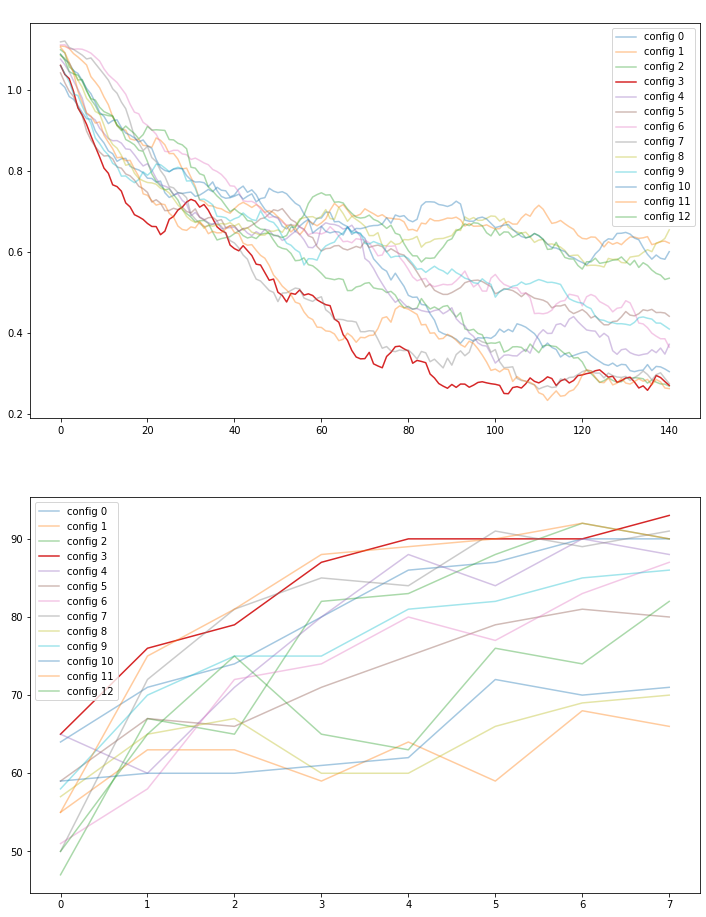

Config 00 | num of layers: 3 | hidden dim: 32 | output method: maxpool
Config 01 | num of layers: 5 | hidden dim: 32 | output method: maxpool
Config 02 | num of layers: 3 | hidden dim: 64 | output method: maxpool
Config 03 | num of layers: 3 | hidden dim: 64 | output method: maxpool
Config 04 | num of layers: 5 | hidden dim: 64 | output method: maxpool
Config 05 | num of layers: 3 | hidden dim: 32 | output method: avg
Config 06 | num of layers: 5 | hidden dim: 32 | output method: avg
Config 07 | num of layers: 3 | hidden dim: 64 | output method: avg
Config 08 | num of layers: 5 | hidden dim: 64 | output method: avg
Config 09 | num of layers: 3 | hidden dim: 32 | output method: original
Config 10 | num of layers: 5 | hidden dim: 32 | output method: original
Config 11 | num of layers: 3 | hidden dim: 64 | output method: original
Config 12 | num of layers: 5 | hidden dim: 64 | output method: original


In [29]:
import pickle

saved_configs = []
with open('best_models.pickle', 'rb') as f:
    try:
        while True:
            saved_configs.append(pickle.load(f))
    except EOFError:
        pass
print(len(saved_configs))

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

window_width = 10
config_explans = []
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,16))
for n, c in enumerate(saved_configs):
    alpha = 0.4 if n != 3 else 1

    data = np.array(c['loss_list'][:150])
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    sns.lineplot(range(len(ma_vec)), ma_vec, label=f'config {n}', ax=ax1, alpha=alpha)

    data_ = [x.item() for x in c['v_accs_list'][:8]]
    sns.lineplot(range(len(data_)), data_, label=f'config {n}', ax=ax2, alpha=alpha)

    config_explans.append(f'Config {n:02} | num of layers: {c["layer_dim"]} | hidden dim: {c["hidden_dim"]} | output method: {c["compute_output"]}')

plt.legend()
# plt.ylim([0,2])
ax1.set_title('Training losses for model configurations', c='w')
ax2.set_title('Validation accuracy for model configurations', c='w')
plt.show()

for i in config_explans:
    print(i)

## Part 1.3 (20%)

RNN hidden state. In the code above in the RNNModel and BidirRecurrentModel, we utilise the final hidden state extracted by the model in order to make the final pass through a feed-forward layer towards a final prediction.

a) Can you think of reasons this might not be the best choice? Please write down two variations that could possibly yield better result.

b) Experiment with such alternative approaches in the code below in order to achieve a better result and report it below.

In [0]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch
seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

def train_model(config: dict):
    hidden_dim = config['hidden_dim']
    layer_dim = config['layer_dim']
    bias = config['bias']
    mode = config['mode']

    if config['bidir'] is True:
        model = BidirRecurrentModel(mode, input_dim, hidden_dim, layer_dim, bias, output_dim)
    else:
        model = RNNModel(mode, input_dim, hidden_dim, layer_dim, bias, output_dim)

    if torch.cuda.is_available():
        model.cuda()
        
    criterion = nn.CrossEntropyLoss()

    ## YOU MAY CONFIGURE THESE.
    learning_rate = config['learning_rate']
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time()
    loss_list, v_accs_list = [], []
    iter = 0
    max_v_accuracy = 0
    reported_t_accuracy = 0
    max_t_accuracy = 0
    for epoch in range(num_epochs):
        for i, (audio, labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                labels = Variable(labels.cuda())
            else:
                audio = Variable(audio.view(-1, seq_dim, input_dim))
                labels = Variable(labels)

            optimizer.zero_grad()

            outputs = model(audio)

            loss = criterion(outputs, labels)

            if torch.cuda.is_available():
                loss.cuda()

            loss.backward()

            optimizer.step()

            loss_list.append(loss.item())
            iter += 1

            if iter % valid_every_n_steps == 0:
                correct = 0
                total = 0
                for audio, labels in valid_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                v_accuracy = 100 * correct / total
                v_accs_list.append(v_accuracy)
                
                is_best = False
                if v_accuracy >= max_v_accuracy:
                    max_v_accuracy = v_accuracy
                    is_best = True

                if is_best:
                    for audio, labels in test_loader:
                        if torch.cuda.is_available():
                            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                        else:
                            audio = Variable(audio.view(-1, seq_dim, input_dim))

                        outputs = model(audio)

                        _, predicted = torch.max(outputs.data, 1)

                        total += labels.size(0)

                        if torch.cuda.is_available():
                            correct += (predicted.cpu() == labels.cpu()).sum()
                        else:
                            correct += (predicted == labels).sum()

                    t_accuracy = 100 * correct / total
                    reported_t_accuracy = t_accuracy

                print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {} Elapsed time: {:.1f}s'.format(iter, loss.item(), v_accuracy, reported_t_accuracy, time() - start_time))

    return loss_list, v_accs_list

In [10]:
from time import time
import pickle
from itertools import product
from google.colab import files

num_epochs = 2

model_premutations = {
    'compute_output' : ['maxpool', 'avg', 'original'],
    'hidden_dim' : [32, 64],
    'layer_dim' : [3, 5],
}

for n, params in enumerate(list(product(*model_premutations.values()))):
    if n < 2:
        continue

    # Set up model config
    config = {
        'hidden_dim' : params[1],
        'layer_dim' : params[2],      
        'bias' : True,
        'learning_rate' : 1e-2,
        'mode' : 'GRU',
        'bidir' : True,
        'compute_output' : params[0],
        'loss_list' : [],
        'v_accs_list' : [],
    }

    # Train model
    print(f'Training model {n+1} / {len(list(product(*model_premutations.values())))} \t config: \n{config}')
    loss_list, v_accs_list = train_model(config)

    # Save results
    config['loss_list'] = loss_list
    config['v_accs_list'] = v_accs_list
    with open('best_models.pickle', 'ab') as f:       # 'ab' for append (bytes) mode; this way it doens't overwite the prev. saved outputs...)
        pickle.dump(config, f)

    # Download file to local device (in case of runtime disconnecting)
    files.download('best_models.pickle')

# # Run below to load saved results
# saved_configs = []
# with open('model_results.pickle', 'rb') as f:
#     try:
#         while True:
#             saved_configs.append(pickle.load(f))
#     except EOFError:
#         pass
# print(len(saved_configs))

Training model 3 / 12 	 config: 
{'hidden_dim': 64, 'layer_dim': 3, 'bias': True, 'learning_rate': 0.01, 'mode': 'GRU', 'bidir': True, 'compute_output': 'maxpool', 'loss_list': [], 'v_accs_list': []}
Iteration: 20. Loss: 0.772550642490387. V-Accuracy: 65  T-Accuracy: 64 Elapsed time: 39.2s
Iteration: 40. Loss: 0.7388840317726135. V-Accuracy: 76  T-Accuracy: 75 Elapsed time: 77.7s
Iteration: 60. Loss: 0.3264303207397461. V-Accuracy: 79  T-Accuracy: 79 Elapsed time: 116.9s
Iteration: 80. Loss: 0.26847735047340393. V-Accuracy: 87  T-Accuracy: 85 Elapsed time: 155.7s
Iteration: 100. Loss: 0.3083202540874481. V-Accuracy: 90  T-Accuracy: 91 Elapsed time: 193.7s
Iteration: 120. Loss: 0.2554677128791809. V-Accuracy: 90  T-Accuracy: 89 Elapsed time: 232.5s
Iteration: 140. Loss: 0.33484959602355957. V-Accuracy: 90  T-Accuracy: 90 Elapsed time: 270.9s
Iteration: 160. Loss: 0.18248958885669708. V-Accuracy: 93  T-Accuracy: 92 Elapsed time: 309.3s
Iteration: 180. Loss: 0.38360661268234253. V-Accurac

## Answers here

a) Two reasons why this may not be a good idea:

 - The final hidden state is likely to be influenced heavily by inputs later on in the sequence and influences less by inputs earlier on in the sequence. This will likely mean that the final state will not accurately caputure the meaning of the whole sequence. This will be especially an issue in longer sequences.

 - This also creates a bottleneck for the gradient flow causing vanishing/exploding gradient issues as the gradient has to flow back through every time step to reach the first time step. This again means that performance on longer sequences suffers and the network struggles to learn from inputs ealier on in the sequence.

Two variations that avoid this issue:

- Max pooling of all hidden states
- Average pooling of all hidden states


## Part 2: Theoretical questions (30%)

Please answer the following theoretical questions in a cell below each respective question.

a. What is the _vanishing and exploding gradients problem_? When does it appear, and what is its practical significance? Please explain. (10%)

* Your answer here.

b. The following (cartoon) plots show the gradients and the training curves for three models A, B, and C, trained on the same dataset. The three models are a RNN, a LSTM and a GRU, not necessarily in that order. (10%)

* Which could plausibly be which? Why? Please explain your reasoning.
* For which kinds of problems would you elect to use each of them?

In [0]:
from IPython.display import Image, display
display(Image(filename='question_figs.png', width=850))

* Your answers here.

c.  Write down five possible Connectionist Temporal Classification (CTC) paths (of no more than a length of eight) that correspond to the same label "LADDER". (10%)

* Your answer here.

In [10]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch

# Add the model that has got the best results for you after after Part 1.2 and Part 1.3

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## YOU MAY CONFIGURE THESE.
hidden_dim = 64
layer_dim = 3
bias = True
# compute_output = 'original'

model = RNNModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim)
# model = BidirRecurrentModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)

if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

## YOU MAY CONFIGURE THESE.
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct / total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()
                t_accuracy = 100 * correct / total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))



Iteration: 20. Loss: 0.8405960202217102. V-Accuracy: 60  T-Accuracy: 59
Iteration: 40. Loss: 0.7705747485160828. V-Accuracy: 58  T-Accuracy: 59
Iteration: 60. Loss: 0.7168287634849548. V-Accuracy: 62  T-Accuracy: 60


KeyboardInterrupt: ignored